# **Question 3:**

In [2]:
# Getting the post reader
from post_parser_record import PostParserRecord
post_reader = PostParserRecord("Posts_Coffee.xml")

In [3]:
# Getting the tokenizer
!pip install nltk 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords  

stop_words = set(stopwords.words('english'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
import string
import re

# Cleans the text

def clean_string(s):
  # Removes HTML tags
  CLEANR = re.compile('<.*?>') 
  s = re.sub(CLEANR, '', s)
  # Removes newlines and adds a space so that words do not combine
  s = s.replace('\n', ' ') 
  # Removes punctuation
  s = s.translate(str.maketrans('','',string.punctuation))
  
  return s

In [6]:
# Creates the Inverted Index

inverted_index = {}

# Gathering Question Data
for question_id in post_reader.map_questions:
  
  doc_freq = {}

  # Gets question
  question = post_reader.map_questions[question_id]

  # Combines question body and title
  question_b = question.body.lower().strip()
  question_t = question.title.lower().strip()
  question_bt = question_b + " " + question_t

  # Cleaning
  question_bt = clean_string(question_bt)

  # Tokenizing
  token_words = nltk.word_tokenize(question_bt)
  token_words = [w for w in token_words if not w.lower() in stop_words]
  token_words.sort()

  for token in token_words:   # Loop through tokens
    if token in inverted_index:     # Token is already in index
      doc_freq = inverted_index[token]  # Sets doc_freq to the current postings/counts for the token
      if question_id in doc_freq:
        freq = doc_freq[question_id] + 1
        doc_freq.update({question_id: freq})
        doc_freq = dict(sorted(doc_freq.items(), key=lambda item: item[1], reverse=True))
        inverted_index.update({token: doc_freq})
      else:
        doc_freq.update({question_id: 1})
    else:   # Token is not in index, adds to index with a frequency of 1
      doc_freq = {question_id: 1}     
      inverted_index.update({token: doc_freq})
      

# Gathering Answer Data
for answer_id in post_reader.map_just_answers:
 
  doc_freq = {}

  # Gets answer and text
  answer = post_reader.map_just_answers[answer_id]
  answer_text = answer.body.lower().strip()

  # Cleaning
  answer_text = clean_string(answer_text)

  # Tokenizing
  token_words2 = nltk.word_tokenize(answer_text)
  token_words2 = [w for w in token_words2 if not w.lower() in stop_words]
  token_words2.sort()

  for token in token_words2:   # Loop through tokens
    if token in inverted_index:     # Token is already in index
      doc_freq = inverted_index[token]  
      if answer_id in doc_freq:
        freq = doc_freq[answer_id] + 1
        doc_freq.update({answer_id: freq})
        doc_freq = dict(sorted(doc_freq.items(), key=lambda item: item[1], reverse=True))
        inverted_index.update({token: doc_freq})
      else:
        doc_freq.update({answer_id: 1})
    else:   # Token is not in index, adds to index with a frequency of 1
      doc_freq = {answer_id: 1}     
      inverted_index.update({token: doc_freq})



# Sorting keys 
sorted_keys = sorted(inverted_index.keys())
inverted_index = {key:inverted_index[key] for key in sorted_keys}

In [7]:
def retrieve_by_freq(dict1, dict2):
  # These are doc lists in sorted order
  list1 = list(sorted(dict1))
  list2 = list(sorted(dict2))
  doc_count = {}
  matches = []
  i = 0
  j = 0
  count = 0

  # Loop to run through each doc for first term
  while i < len(list1) and j < len(list2):
      if list1[i] < list2[j]:
        count = dict1[list1[i]]
        doc_count.update({list1[i]: count})
        matches.append(list1[i])
        i += 1
      elif list2[j] < list1[i]:
        count = dict2[list2[j]]
        doc_count.update({list2[j]: count})
        j += 1
      else:
        count = dict2[list2[j]] + dict1[list1[i]]
        doc_count.update({list2[j]: count})
        i += 1
        j += 1
  
  # Add rest of list1 to matches
  while i < len(list1):
      count = dict1[list1[i]]
      doc_count.update({list1[i]: count})
      i += 1
  
  # Add rest of list2 to matches
  while j < len(list2):
      count = dict2[list2[j]]
      doc_count.update({list2[j]: count})
      j += 1

  # Sorts by value (how many times the words appear in the doc)
  doc_count = dict(sorted(doc_count.items(), key=lambda item: item[1], reverse=True))

  # Set matches to the list of docs in doc_count
  matches = list(doc_count.keys())

  return matches

In [8]:
# Function to do retrieval, ranking by frequency of the words in the document
def freq_search (query):
  # Breaks up search terms
  search_terms = query.split()

  # Case for all inputs not in index
  for term in search_terms:
    if term in inverted_index:
      break
    elif term not in inverted_index and term != search_terms[len(search_terms) - 1]:
      search_terms.remove(term)
    elif term == search_terms[len(search_terms) - 1]:
      return "No results"
    
  # Single search
  if len(search_terms) == 1:
    return list(inverted_index[search_terms[0]].keys())
  
  else: # Search for more than 1 term
    return retrieve_by_freq(inverted_index[search_terms[0]], inverted_index[search_terms[1]])


### Part 1

In [9]:
# a.
a = freq_search('espresso')
print(a)

[3269, 1574, 2095, 283, 5537, 2077, 2116, 3721, 2087, 3438, 1630, 4895, 3284, 3956, 288, 1651, 2208, 5377, 470, 1840, 3694, 3764, 4000, 5837, 2766, 3252, 4618, 135, 324, 2102, 2433, 2687, 3720, 4259, 4422, 5057, 5095, 5685, 5764, 2791, 3518, 3768, 3894, 4279, 4727, 4880, 5277, 5730, 5742, 419, 466, 2316, 2399, 3184, 3186, 3771, 3958, 4041, 4407, 5528, 5536, 5824, 26, 1860, 2562, 3362, 3812, 3953, 4860, 5152, 5400, 5786, 5886, 1526, 2124, 2644, 2706, 2710, 2966, 3402, 3689, 3927, 4176, 4262, 4412, 4683, 4749, 5544, 5608, 5863, 1572, 1951, 2017, 2265, 2350, 2705, 2745, 2957, 2959, 3113, 3434, 4128, 4175, 4258, 4261, 4275, 4401, 4755, 4928, 5053, 5166, 5357, 5433, 5604, 5687, 168, 175, 308, 427, 480, 1685, 2290, 2355, 2665, 2769, 2869, 3001, 3285, 3363, 3685, 3724, 4069, 4138, 4148, 4207, 4234, 4330, 4400, 4405, 4975, 5171, 5530, 5532, 5603, 5673, 5684, 5795, 5825, 164, 257, 296, 399, 463, 1668, 1793, 1977, 2067, 2100, 2314, 2352, 2394, 2867, 2964, 3168, 3411, 3491, 3495, 3665, 3713, 3800

In [10]:
# b.
b = freq_search('turkish coffee')
print(b)

[3269, 2820, 2392, 33, 4385, 4422, 3648, 438, 194, 324, 2540, 3161, 3531, 4350, 1933, 2077, 5815, 181, 3267, 3391, 4407, 1833, 3402, 3423, 3699, 4273, 46, 1555, 1615, 1630, 2151, 3018, 3604, 4134, 4185, 4627, 5806, 138, 1528, 1730, 1741, 1791, 2114, 3101, 3184, 4294, 5095, 5739, 312, 1713, 2301, 3854, 3870, 4126, 4170, 430, 2379, 2453, 2647, 3195, 3272, 3727, 3939, 4065, 4140, 4641, 5397, 165, 1669, 2116, 2158, 2431, 3165, 3583, 3710, 3869, 4696, 4971, 5040, 5304, 5306, 1617, 1852, 1918, 2305, 2370, 2394, 2667, 2708, 2825, 3040, 3655, 4127, 4147, 4856, 5058, 5152, 5272, 5343, 5683, 5860, 162, 1503, 1609, 1873, 1998, 2340, 2556, 2603, 2797, 3186, 3224, 3263, 3349, 3428, 3685, 3704, 3739, 3815, 3827, 3898, 3914, 4131, 4257, 4368, 4474, 5713, 5764, 106, 166, 216, 475, 497, 1510, 1558, 1881, 1937, 2033, 2259, 2295, 2320, 2594, 2665, 2739, 2840, 2852, 3144, 3162, 3273, 3274, 3278, 3485, 3506, 3514, 3600, 3652, 3653, 3654, 3693, 3732, 3746, 3764, 3927, 4020, 4120, 4255, 4411, 4654, 4683, 469

In [11]:
# c. 
c = freq_search('persian coffee')
print(c)

[3269, 2820, 33, 4385, 4422, 2392, 3648, 438, 4350, 194, 324, 2540, 3161, 3531, 1933, 2077, 5815, 181, 3267, 3391, 3402, 3423, 3699, 1615, 46, 1555, 1630, 2151, 3018, 3604, 4134, 4273, 4407, 4627, 5806, 5739, 138, 1528, 1730, 1741, 1791, 2114, 3184, 4185, 4294, 312, 1713, 2301, 3854, 3870, 4126, 4170, 430, 2453, 3195, 3272, 3727, 4065, 4140, 4641, 5397, 1669, 2116, 2158, 2431, 3165, 3583, 3869, 3939, 4696, 4971, 5040, 5304, 5306, 1833, 4127, 5152, 5272, 5343, 5683, 5860, 165, 1617, 1852, 1918, 2305, 2370, 2708, 3040, 3655, 3710, 4147, 4856, 5058, 3263, 3815, 5713, 162, 1503, 1609, 1873, 2340, 2556, 2603, 3101, 3186, 3349, 3428, 3685, 3704, 3827, 3914, 4131, 4368, 5095, 5764, 2594, 3144, 3273, 3485, 3693, 3898, 4020, 4411, 4721, 4735, 5619, 5886, 166, 475, 497, 1510, 1558, 1881, 1937, 2033, 2259, 2295, 2320, 2647, 2739, 2840, 3162, 3224, 3274, 3278, 3506, 3514, 3600, 3652, 3653, 3654, 3732, 3746, 3764, 3927, 4120, 4255, 4257, 4654, 4683, 4695, 4725, 4844, 4866, 5517, 5775, 5904, 1998, 2

## Part 2

## a. 

In [12]:
from prettytable import PrettyTable

myTable = PrettyTable(["Query", "First 10 results"])
 
# Adds rows
myTable.add_row(["espresso", a[:10]])
myTable.add_row(["turkish coffee", b[:10]])
myTable.add_row(["persian coffee", c[:10]])

print(myTable)

+----------------+-------------------------------------------------------------+
|     Query      |                       First 10 results                      |
+----------------+-------------------------------------------------------------+
|    espresso    | [3269, 1574, 2095, 283, 5537, 2077, 2116, 3721, 2087, 3438] |
| turkish coffee |   [3269, 2820, 2392, 33, 4385, 4422, 3648, 438, 194, 324]   |
| persian coffee |   [3269, 2820, 33, 4385, 4422, 2392, 3648, 438, 4350, 194]  |
+----------------+-------------------------------------------------------------+


In [13]:
myTable = PrettyTable(["Query", "Precision@10"])
 
myTable.add_row(["espresso", "8/10"])   # 283 not relevant (talks about space espresso), 3438 not relevant (talks about ordering, not making espresso)
myTable.add_row(["turkish coffee", "2/10"]) # 2820, 33, 4385, 4422, 3648, 438, 194, 324 not relevant
myTable.add_row(["persian coffee", "0/10"]) # All not relevant

print(myTable)

+----------------+--------------+
|     Query      | Precision@10 |
+----------------+--------------+
|    espresso    |     8/10     |
| turkish coffee |     2/10     |
| persian coffee |     0/10     |
+----------------+--------------+


To decide relevance I simply referenced the post in the xlm document and checked if it answered or mentioned the information need.

## b.

None of my first 10 results for any of the three queries matched the first 10 results in assignment 1. Similiarly between these results and assignment 1's results is the precision of at cut 10 of 'espresso'. Overall these results are very different from Assignment 1's as the precision is lower overall, although more documents are added for queries that used an 'and' in assignment 1. Similarly though, the persian coffee had the same precision as in assignment 1 as there is no mention of 'persian coffee' in any posts.

## c.

In [14]:
import csv
import os
from functools import reduce


with open('inverted_index.tsv', 'w') as indexFile:

        # declaring the fieldnames for the CSV file
        fieldNames = ['Token ', 'DocID : Frequency']

        # creating a DictWriter object
        csvWriter = csv.DictWriter(indexFile, fieldnames= fieldNames)

        # writing the header
        csvWriter.writeheader()

        for token, fileDetails in inverted_index.items():

            # creating a string of all the doc id's and their frequency 
            DocIDFreq = reduce(lambda x, y: x + "" + y, str(inverted_index[token]))

            # writing the row
            csvWriter.writerow({'Token ': token, 'DocID : Frequency': DocIDFreq})

# **Question 4:**

In [15]:
from re import search

def build_qrel ():
  # query_id
  search1 = 1
  search2 = 2
  search3 = 3

  writeList = []
  writeList2 = []
  writeList3 = []

  relevance = 0
  
  for doc in a:
    if doc in post_reader.map_just_answers:
      answer = post_reader.map_just_answers[doc]
      text = answer.body.lower().strip()
    elif doc in post_reader.map_questions:
        # Gets question
        question = post_reader.map_questions[doc]
        question_b = question.body.lower().strip()
        question_t = question.title.lower().strip()
        text = question_b + " " + question_t

    if search("make espresso", text) or search("brew espresso",text) or search("own espresso",text) or search("making espresso",text) or search("espresso making",text) or search("espresso machine",text):
        relevance = 1
    else:
        relevance = 0
    writeList.append(str(search1) + " " + str(0) + " " + str(doc) + " " + str(relevance) + "\n")

  for doc in b:
    if doc in post_reader.map_just_answers:
      answer = post_reader.map_just_answers[doc]
      text = answer.body.lower().strip()
    elif doc in post_reader.map_questions:
        # Gets question
        question = post_reader.map_questions[doc]
        question_b = question.body.lower().strip()
        question_t = question.title.lower().strip()
        text = question_b + " " + question_t

    if search("make turkish coffee",text) or search("brew turkish coffee",text) or search("own turkish coffee", text):
        relevance = 1
    else:
        relevance = 0
    writeList2.append(str(search2) + " " + str(0) + " " + str(doc) + " " + str(relevance) + "\n")

  for doc in c:
    if doc in post_reader.map_just_answers:
      answer = post_reader.map_just_answers[doc]
      text = answer.body.lower().strip()
    elif doc in post_reader.map_questions:
        # Gets question
        question = post_reader.map_questions[doc]
        question_b = question.body.lower().strip()
        question_t = question.title.lower().strip()
        text = question_b + " " + question_t
    
    if search("make persian coffee", text) or search("brew persian coffee", text) or search("own persian coffee", text):
        relevance = 1
    else:
        relevance = 0

    writeList3.append(str(search3) + " " + str(0) + " " + str(doc) + " " + str(relevance) + "\n")
  
  with open('qrel.tsv', 'w') as f:
    f.writelines(writeList)
    f.writelines(writeList2)
    f.writelines(writeList3)

  

In [16]:
# This function is only to get the dictionary for use in creating the runfile
def retrieve_by_freq2(dict1, dict2):
  # These are doc lists in sorted order
  list1 = list(sorted(dict1))
  list2 = list(sorted(dict2))
  doc_count = {}
  matches = []
  i = 0
  j = 0
  count = 0

  # Loop to run through each doc for first term
  while i < len(list1) and j < len(list2):
      if list1[i] < list2[j]:
        count = dict1[list1[i]]
        doc_count.update({list1[i]: count})
        matches.append(list1[i])
        i += 1
      elif list2[j] < list1[i]:
        count = dict2[list2[j]]
        doc_count.update({list2[j]: count})
        j += 1
      else:
        count = dict2[list2[j]] + dict1[list1[i]]
        doc_count.update({list2[j]: count})
        i += 1
        j += 1
  
  # Add rest of list1 to matches
  while i < len(list1):
      count = dict1[list1[i]]
      doc_count.update({list1[i]: count})
      i += 1
  
  # Add rest of list2 to matches
  while j < len(list2):
      count = dict2[list2[j]]
      doc_count.update({list2[j]: count})
      j += 1

  # Sorts by value (how many times the words appear in the doc)
  doc_count = dict(sorted(doc_count.items(), key=lambda item: item[1], reverse=True))

  return doc_count

In [17]:
# This This function is only to get the dictionary for use in creating the runfile
def freq_search2 (query):
  # Breaks up search terms
  search_terms = query.split()

  # Case for all inputs not in index
  for term in search_terms:
    if term in inverted_index:
      break
    elif term not in inverted_index and term != search_terms[len(search_terms) - 1]:
      search_terms.remove(term)
    elif term == search_terms[len(search_terms) - 1]:
      return "No results"
    
  # Single search
  if len(search_terms) == 1:
    return inverted_index[search_terms[0]]
  
  else: # Search for more than 1 term
    return retrieve_by_freq2(inverted_index[search_terms[0]], inverted_index[search_terms[1]])

In [18]:
def build_runfile ():
  # query_id
  search1 = 1
  search2 = 2
  search3 = 3

  writeList = []
  writeList2 = []
  writeList3 = []

  i = 1;

  s1 = freq_search2('espresso')
  s2 = freq_search2('turkish coffee')
  s3 = freq_search2('persian coffee')

  for doc in a:
    writeList.append(str(search1) + " Q" + str(0) + " " + str(doc) + " " + str(i) + " " + str(s1[doc]) + " " + "STANDARD" + "\n")
    i += 1
  i = 1
  for doc in b:
    writeList.append(str(search2) + " Q" + str(0) + " " + str(doc) + " " + str(i) + " " + str(s2[doc]) + " " + "STANDARD" + "\n")
    i += 1
  i = 1
  for doc in c:
    writeList.append(str(search3) + " Q" + str(0) + " " + str(doc) + " " + str(i) + " " + str(s3[doc]) + " " + "STANDARD" + "\n")
    i += 1

  with open('runfile.tsv', 'w') as f:
    f.writelines(writeList)
    f.writelines(writeList2)
    f.writelines(writeList3)

In [19]:
build_qrel()

In [20]:
build_runfile()

## a.

The P@5 of my system is 0.2000 and the nDCG@5 of my system is 0.1490.

## b.

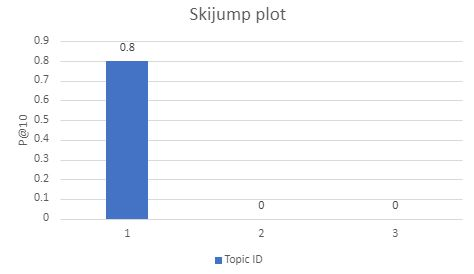

In [22]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread('skijump.JPG')
 
cv2_imshow(img)

It appears my system works very well for single queries such as "espresso" and not so great on other queries, however, this is slightly skewed as there are no documents relevant to query 3 so no matter my system, the precision at 10 would be 0.

# **Question 5:** 

In [23]:
import scipy.stats as stats

#Recip rank
x1 = [0.6103, 0.4339, 0.1003,0.0854,0.8640, 0.2811,0.0237, 0.4196, 0.3857, 0.2432]
#P@10
x2 = [0.3566,0.1818,0.0584,0.0519, 0.5479, 0.1883,0.0039, 0.2403, 0.2390, 0.1390]

tau, p_value = stats.kendalltau(x1, x2)

print("Tau: " + str(tau))
print("p_value " + str(p_value))

Tau: 0.8666666666666666
p_value 0.00011518959435626102


It does not seem like the two effectiveness measures are showing the same system rankings. There does seem to be a correlation between the two measures. however, as the recip rank is always about double that of P@10. The numbers seem to grow and shrink together. The correlation between the two seems to be that they are both getting the average relevance at different ranks.